# AE Training

## Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, train_test_split, Scaler
from data_evaluation.predictive.TimeSeriesDataset import TimeSeriesDataset
from AE import LSTMAE, train_autoencoder

In [3]:
TEST_EXISTING_MODEL = False

In [4]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

In [5]:
model_name = "LSTM_AE"
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0002,
    "batch_size": 32,
    "num_epochs": 2000,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

## Data

In [6]:
traffic_df = pd.read_csv(REAL_DATA_FOLDER / "mitv_prep_1y.csv")
traffic_df.shape

(8759, 5)

In [7]:
traffic_np = traffic_df.to_numpy()
traffic_np.shape

(8759, 5)

### Preprocessing

In [8]:
# Train test split
train, test = train_test_split(traffic_np, split_ratio=0.8)
test, val = train_test_split(test, split_ratio=0.5)

In [9]:
# scale data
scaler = Scaler(train)
train_scaled = scaler.scale_data(train)
val_scaled = scaler.scale_data(val)
test_scaled = scaler.scale_data(test)

In [10]:
# split data into sequences
train_seq_scaled = split_data_into_sequences(train_scaled, hyperparameters['seq_len'], shuffle_data=False)
val_seq_scaled = split_data_into_sequences(val_scaled, hyperparameters['seq_len'], shuffle_data=False)
test_seq_scaled = split_data_into_sequences(test_scaled, hyperparameters['seq_len'], shuffle_data=False)

Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)
Shape of the data after splitting into sequences: (865, 12, 5)


In [11]:
# create datasets
# NOTE: The targets are not used in the training process, but are required by the PyTorch Dataset class
train_dataset = TimeSeriesDataset(train_seq_scaled, np.zeros((train_seq_scaled.shape[0], 1)))
val_dataset = TimeSeriesDataset(val_seq_scaled, np.zeros((val_seq_scaled.shape[0], 1)))
test_dataset = TimeSeriesDataset(test_seq_scaled, np.zeros((test_seq_scaled.shape[0], 1)))

In [12]:
# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)

In [13]:
X_train, y = next(iter(train_loader))

## Autoencoder

In [14]:
model = LSTMAE().to(hyperparameters['device'])

## Training

In [15]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=hyperparameters['lr'])
criterion = nn.L1Loss()

In [ ]:
if TEST_EXISTING_MODEL:
    model_path = f"{model_name}_best.pth"
else:
    model_path = f"{model_name}_checkpoint.pth"

    train_losses, val_losses = train_autoencoder(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        save_path=model_path
    )

## Evaluate Training

In [33]:
if not TEST_EXISTING_MODEL:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Diagramm 1 (oben links)
    axs[0].plot(train_losses, label="BCELoss")
    axs[0].set_title('Training Loss')

    axs[1].plot(val_losses, label="BCELoss")
    axs[1].set_title('Validation Loss')

In [34]:
if not TEST_EXISTING_MODEL:
    smallest_val_loss = val_losses[-11]
    smallest_train_loss = train_losses[-11]
    print(f'Smallest Val Loss: {smallest_val_loss} | Smallest Train Loss: {smallest_train_loss}')

## Testing Model

In [35]:
test_model = LSTMAE().to(hyperparameters['device'])
# load model state dict
test_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

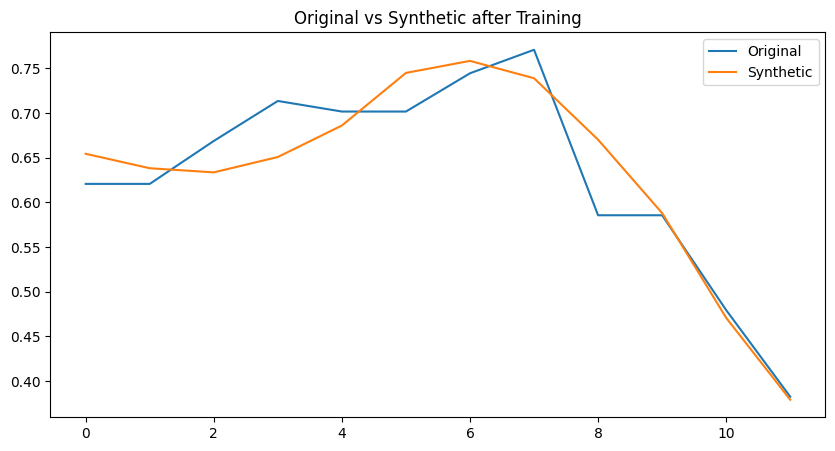

In [36]:
random_idx = random.randint(0, len(train_dataset) - 1)
random_test_sample = torch.tensor(train_dataset[random_idx][0], dtype=torch.float32).unsqueeze(0)
random_test_sample = random_test_sample.float().to(hyperparameters['device'])

test_model.eval()
with torch.inference_mode():
    test_pred = test_model(random_test_sample)

test_plot = dc(random_test_sample.detach().numpy())
pred_plot = dc(test_pred.detach().numpy())

# plot the original and synthetic test data
plt.figure(figsize=(10, 5))
plt.title(f'Original vs Synthetic after Training')
plt.plot(test_plot[0, :, 0], label='Original')
plt.plot(pred_plot[0, :, 0], label='Synthetic')
plt.legend()

In [37]:
test_model.eval()
with torch.inference_mode():
    syn_train = test_model(torch.tensor(train_seq_scaled, dtype=torch.float32))
    syn_test = test_model(torch.tensor(test_seq_scaled, dtype=torch.float32))
    syn_val = test_model(torch.tensor(val_seq_scaled, dtype=torch.float32))

In [38]:
syn_train.shape, syn_test.shape, syn_val.shape

(torch.Size([6996, 12, 5]), torch.Size([865, 12, 5]), torch.Size([865, 12, 5]))

In [39]:
syn_train = syn_train.detach().numpy()
syn_test = syn_test.detach().numpy()
syn_val = syn_val.detach().numpy()

In [40]:
result = np.concatenate([syn_train, syn_val, syn_test], axis=0)

In [41]:
result.shape

(8726, 12, 5)

In [42]:
result_unscaled = scaler.inverse_scale_complete_dataset(result, input_data_is_sequential=True)

In [43]:
no, seq, dim = result_unscaled.shape
data_to_save = result_unscaled.reshape(no, seq*dim)

In [44]:
# np.savetxt(f'mitv_{no}_{seq}_{dim}_autoencoder_{model_name}_unscaled.csv', data_to_save, delimiter=',')

### Check on synthetic data

In [45]:
df = pd.DataFrame(result_unscaled.reshape(-1, dim))
df.describe()

,0,1,2,3,4
count,104712.000000,104712.000000,104712.0,1.047120e+05,104712.000000
mean,3196.964111,279.349884,0.0,1.266347e-09,40.697540
std,1877.608887,14.884194,0.0,4.027184e-07,39.007477
min,0.000000,247.150009,0.0,0.000000e+00,0.000000
25%,1297.783539,271.447609,0.0,0.000000e+00,0.000000
50%,3544.542114,281.756729,0.0,0.000000e+00,31.727083
75%,4784.060547,291.352676,0.0,0.000000e+00,86.484615
max,7716.058105,307.195068,0.0,1.302962e-04,110.427353


In [46]:
traffic_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,3244.668912,282.208136,0.086792,0.000233,44.397306
std,1946.247953,12.114907,0.901360,0.006145,39.195308
min,0.000000,243.390000,0.000000,0.000000,0.000000
25%,1252.500000,273.605500,0.000000,0.000000,1.000000
50%,3402.000000,283.650000,0.000000,0.000000,40.000000
75%,4849.500000,292.060000,0.000000,0.000000,90.000000
max,7260.000000,307.330000,42.000000,0.250000,100.000000
